# Spike Sorting

There were 3298 spikes that were detected (as can be verified by looking at the shape of the spikes variable). Use the spike times to extract the spike waveforms each of length 70 samples in a variable called waveforms. waveforms should be of shape 3298 × 70. Note that the spike times given to you are such that you can just take the 70 samples including and after the spike time of each spike, i.e., you don’t need to do anything else to center the spike peak over the 70 samples.


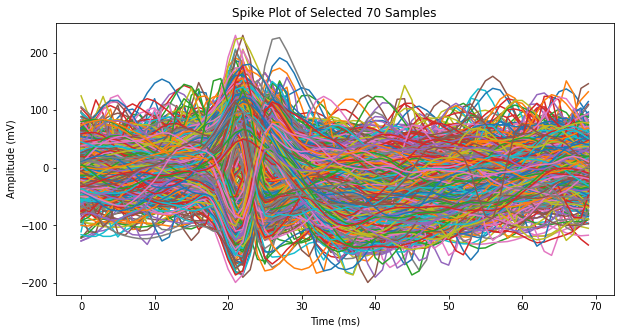

In [3]:
#Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import scipy.io as sio

# Plot these spike waveforms on top of each other.
spikedata = sio.loadmat('SpikeSorting.mat',squeeze_me=True)
spikedata.keys()
spikes = spikedata['spikes']
voltage = spikedata['voltage']

#create empty waveform matrix
waveform = np.zeros((3298,70))
#loop through all values of spikes in voltages
for n  in range(len(spikes)):
    array = voltage[(spikes[n]):(spikes[n] + 70)]
    waveform [n,:]= array

#plot spikes in transpose waveform
pl.figure(figsize=(10,5))
pl.plot(waveform.T)
pl.xlabel('Time (ms)')
pl.ylabel('Amplitude (mV)')
pl.title('Spike Plot of Selected 70 Samples')
pl.show()

## Attempt to reduce through PCA. 
Considering every spike a point in 70 dimensional space, we want to determine the orthogonal set with maximum variability across the 3298 points. to do this we need to calculate the covariance of the original 70 axes.

Text(0, 0.5, 'Sample Numbers')

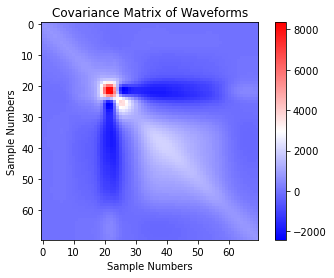

In [5]:
# first estimate the 70 x 70 covariance matrix treating each time point as a seperate axis (or variable)
# and each spike example as a different observation of those 70 varaiables

## Note data given is in 16 bit integers convert into double to avoid errors in calculation ##
waveform = waveform.astype('double')
C = np.cov(waveform.T)

# Plot the covariance matrix as an image with hotter colors indicating negative numbers.
im = pl.imshow(C, cmap='bwr')
pl.colorbar(im)
pl.title('Covariance Matrix of Waveforms')
pl.xlabel('Sample Numbers')
pl.ylabel('Sample Numbers')

This bright spot in this image shows the point of most correlation between these 70 axes. In general, this should be the value at which most spikeforms have their peaks. The white (hot) band extending along the diagonal from this brightspot represents the variance amongst these peaks to themselves.The darker blue (cool) bands extending from the bright spot represent show a negtive variance between the peaks in the bright spot and these points, this means these points are directly associated with the neural spike with said peak. 

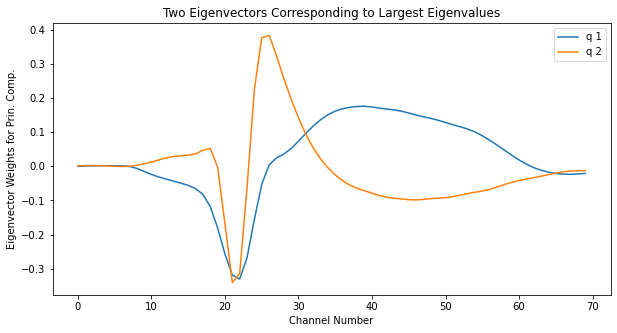

In [6]:
# Extract the two directions of max variability by calculating eigenvectors and choosing the ones corresponding to the largest two eigenvalues.
#Use numpy.linalg.eigh to find eigen values and matrix of eigenvectors for the covariance matrix
eigenval,eigenvec=np.linalg.eigh(C)
#Get last two eigenvectors since the function numpy.linalg.eigh sorts the eigenvectors from low to high eigenvalues
q_1 = eigenvec[:,-1]
q_2 = eigenvec[:,-2]
# Plot these two eigenvectors (q1 and q2) on top of each other with different colors
nchans = np.arange(0,70)
pl.figure(figsize=(10,5))
pl.plot(nchans, q_1)
pl.plot(nchans, q_2)
pl.xlabel('Channel Number')
pl.ylabel('Eigenvector Weights for Prin. Comp.')
pl.title('Two Eigenvectors Corresponding to Largest Eigenvalues')
pl.legend(["q 1","q 2"])
pl.show()

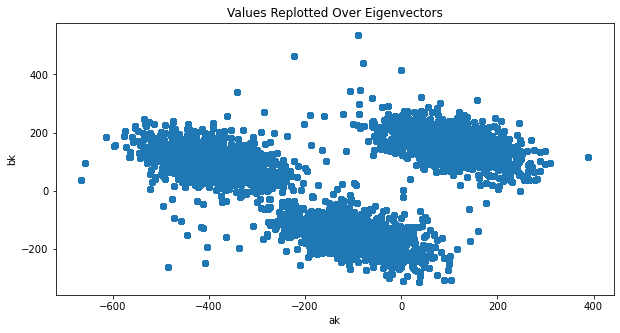

In [7]:
# Project the spikeexample along each of the two eigenvectors
# create ak and bk arrays of the projection of all points onto each eigen vectors
ak = np.zeros(waveform.shape)
bk = np.zeros(waveform.shape)
for k in range(waveform.shape[0]):
    ak[k] = np.dot(waveform[k,:], q_1)
    bk[k] = np.dot(waveform[k,:], q_2)
# Plot each spike as a point in this 2D plane.
pl.figure(figsize=(10,5))
pl.scatter(ak,bk)
pl.xlabel('ak')
pl.ylabel('bk')
pl.title('Values Replotted Over Eigenvectors')
pl.show()

Based on the 2D plot there are three different neurons.This can be seen since there are three different cluters of neurons.

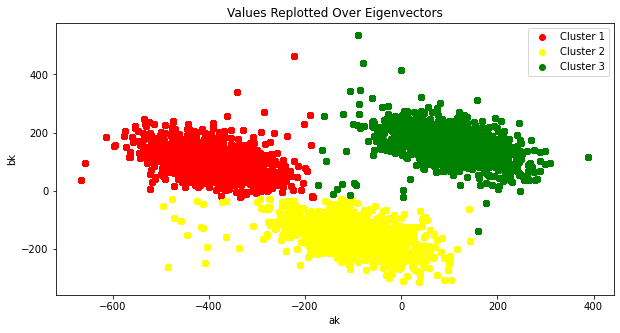

In [8]:
# Manually clustering points
#masking
mask_1 = (ak <= -175) & (bk > -25)
mask_2 = (ak <= 150) & (bk < -25)
mask_3 = ~mask_1 & ~mask_2
#replot the data on this 2D plot now with an assigned color to each cluster to visualize the masks
pl.figure(figsize=(10,5))
pl.scatter(ak[mask_1], bk[mask_1], c='red')
pl.scatter(ak[mask_2], bk[mask_2], c='yellow')
pl.scatter(ak[mask_3], bk[mask_3], c='green')
pl.xlabel('ak')
pl.ylabel('bk')
pl.title('Values Replotted Over Eigenvectors')
pl.legend(["Cluster 1","Cluster 2","Cluster 3"])
pl.show()

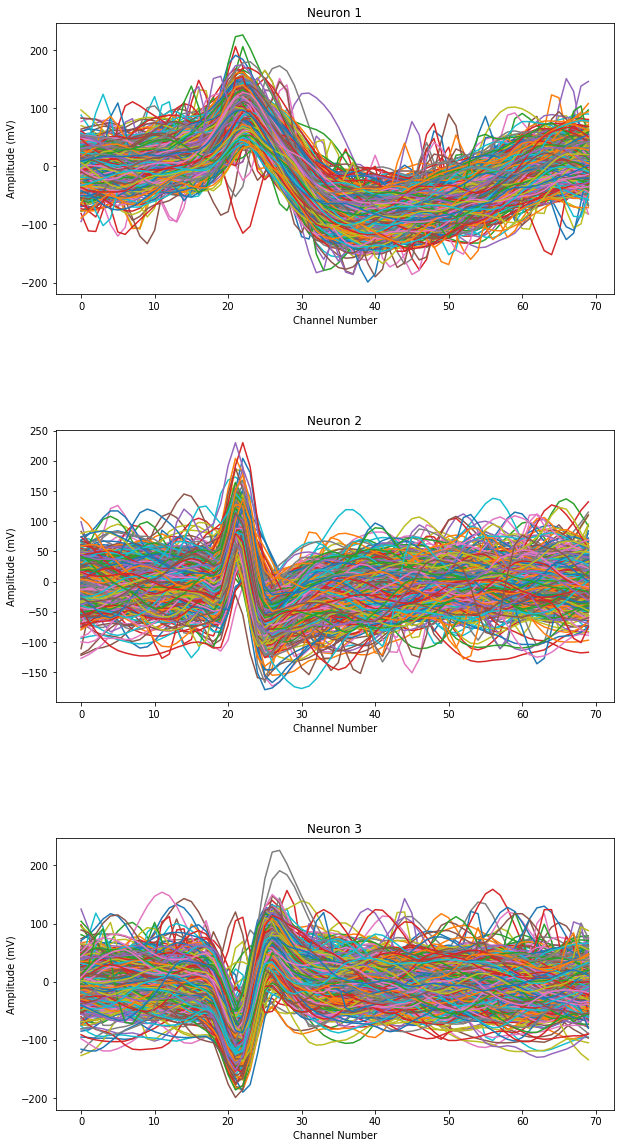

In [9]:
# Plot full spike shapes (i.e., the original 70 dimensional shape) of all the points that belong to any one of the clusters (Let’s call this cluster1).¶
pl.figure(figsize=(10,20))
# Plot full spike shapes Neuron 1
ax1 = pl.subplot(311)
ax1.plot(waveform.T[:,mask_1.T[0]])
pl.title('Neuron 1')
pl.xlabel('Channel Number')
pl.ylabel('Amplitude (mV)')
pl.subplots_adjust(hspace=0.5)

# Plot full spike shapes Neuron 2
ax2 = pl.subplot(312, sharex=ax1)
ax2.plot(waveform.T[:,mask_2.T[0]])
pl.title('Neuron 2')
pl.xlabel('Channel Number')
pl.ylabel('Amplitude (mV)')

# Plot full spike shapes Neuron 3
ax3 = pl.subplot(313, sharex=ax1)
ax3.plot(waveform.T[:,mask_3.T[0]])
pl.title('Neuron 3')
pl.xlabel('Channel Number')
pl.ylabel('Amplitude (mV)')
pl.show()

mean of ak of cluster 1:  -396.9345990985217
mean of bk of cluster 1:  103.17024041755832


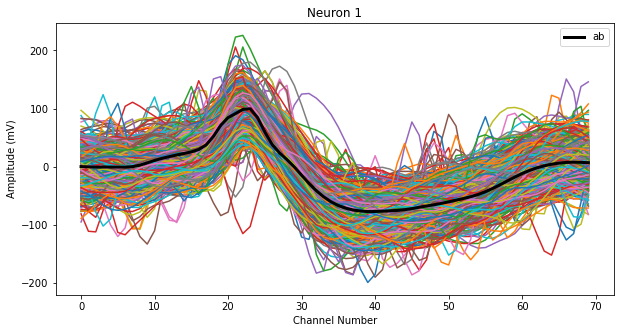

In [10]:
# Calculate the average "a" of the ak values, and the average "b" of the bk values for just the points in cluster 1.
# Calculate means of ak and bk for cluster 1
a = np.mean(ak[mask_1])
b = np.mean(bk[mask_1])
aq1 = a*q_1
bq2 = b*q_2
ab = aq1+bq2
print('mean of ak of cluster 1: ', a)
print('mean of bk of cluster 1: ', b)

# Plot the trace aq1+ bq2 on top of the previous plot of spike shape examples of cluster1
#plot trace of aq1 + bq2 on Neuron 1 spike shape
pl.figure(figsize=(10,5))

pl.plot(waveform.T[:,mask_1.T[0]])
pl.plot(ab,color='black', linewidth=3,label="ab")
pl.title('Neuron 1')
pl.xlabel('Channel Number')
pl.ylabel('Amplitude (mV)')
pl.legend()
pl.show()

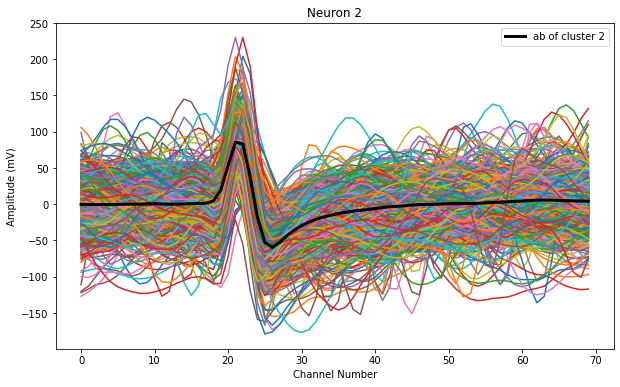

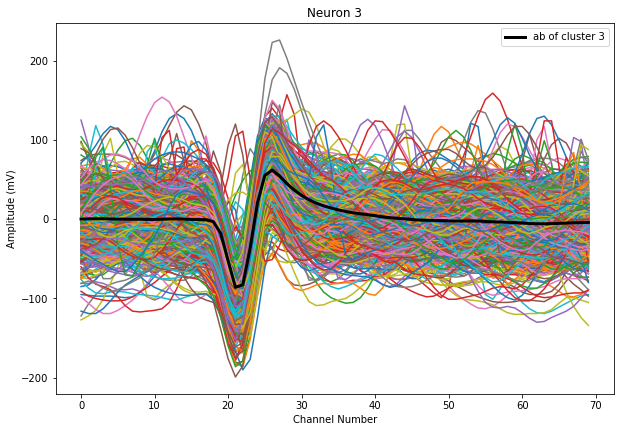

In [11]:
# Calculate means of ak and bk for cluster 2 and cluster 3
a2 = np.mean(ak[mask_2]) #cluster 2
b2 = np.mean(bk[mask_2]) #cluster 2
a3 = np.mean(ak[mask_3]) #cluster 3
b3 = np.mean(bk[mask_3]) #cluster 3

#calculate aq and bq for each cluster
aq12 = a2 * q_1 #cluster 2
bq22 = b2 * q_2 #cluster 2
aq13 = a3 * q_1 #cluster 3
bq13 = b3 * q_2 #cluster 3

#calculate ab
ab2 = aq12 + bq22 #cluster 2
ab3 = aq13 + bq13 #cluster 3

#plot trace of aq1 + bq2 on Neuron 2 and Neuron 3 spike shape
pl.figure(figsize=(10,15))

# Neuron 2
ax1 = pl.subplot(211)
ax1.plot(waveform.T[:,mask_2.T[0]])
pl.plot(ab2, color='black', linewidth=3, label="ab of cluster 2")
pl.title('Neuron 2')
pl.xlabel('Channel Number')
pl.ylabel('Amplitude (mV)')
pl.legend()
pl.subplots_adjust(hspace=0.5)
pl.show()

# Neuron 3
pl.figure(figsize=(10,15))
ax2 = pl.subplot(212)
ax2.plot(waveform.T[:,mask_3.T[0]])
pl.plot(ab3,color='black', linewidth=3, label="ab of cluster 3")
pl.title('Neuron 3')
pl.xlabel('Channel Number')
pl.ylabel('Amplitude (mV)')
pl.legend()
pl.show()

In the plots above we can see that dimensionality reduction is a very effective way of approximating the neuronal shape of spikes. The black line plotted is the mean of the data projected onto the two eigenvectors, then multiplied by the respective eigenvectors,finally then the addition of these two averages together. This shows us what the average of the data would look like if we were to reduce the dimensions to these two prinicipal components q1 and q2. It is very noticible that this approximation with two principal components is a decent one to the actual data.